# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019


# Importando as bibliotecas

In [132]:
import sys 
import numpy as np
from scipy.stats import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Importa pacotes do sklearn
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

# Carregando os dados de treino e teste

In [2]:
def read_data():
    print('Carregando arquivo dataset_treino.csv....')
    train = pd.read_csv('../dataset/dataset_treino.csv')
    print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))

    print('Carregando arquivo dataset_teste.csv....')
    test = pd.read_csv('../dataset/dataset_teste.csv')
    print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))

    return train, test

In [3]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


# Feature Engineering

#### Remover colunas com alta correlação entre si

In [4]:
# Remove colunas com alta correlacao entre si ou com mais de 95% com zeros
train = train.drop(columns = ['v12','v128','v13','v25','v32','v33','v34','v38','v41','v43','v46',
                              'v49','v53','v54','v55','v60','v63','v64','v65','v67','v73','v76','v77',
                              'v8','v83','v87','v89','v95','v96','v97'], axis = 1)

teste = test.drop(columns = ['v12','v128','v13','v25','v32','v33','v34','v38','v41','v43','v46',
                              'v49','v53','v54','v55','v60','v63','v64','v65','v67','v73','v76','v77',
                              'v8','v83','v87','v89','v95','v96','v97'], axis = 1)

#### Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 3 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

### Correlations

In [5]:
# Find correlations with the target and sort
correlations = train.corr()['target'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))


Most Positive Correlations:
 v44       0.046616
v17       0.047620
v61       0.047781
v101      0.050835
v93       0.051708
v106      0.054226
v4        0.059842
v21       0.067634
v72       0.075241
v114      0.075786
v14       0.130670
v129      0.142141
v10       0.148680
v50       0.241683
target    1.000000
Name: target, dtype: float64

Most Negative Correlations:
 v62    -0.093709
v119   -0.058578
v123   -0.055940
v48    -0.055493
v85    -0.050820
v51    -0.049183
v130   -0.046252
v121   -0.044467
v36    -0.040873
v111   -0.040860
v84    -0.040008
v23    -0.032675
v15    -0.032436
v58    -0.032392
v81    -0.031728
Name: target, dtype: float64


#### Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction (removing features that are not relevant) to reduce the size of the datasets.

#### Polynomial Features

In [6]:
poly_data = train[['v62', 'v119', 'v123', 'v48', 'v85','target']]
poly_data_corrs = poly_data.corr()
poly_data_corrs

,v62,v119,v123,v48,v85,target
v62,1.000000,0.038324,0.030082,0.066794,0.011791,-0.093709
v119,0.038324,1.000000,0.862810,0.659285,0.692524,-0.058578
v123,0.030082,0.862810,1.000000,0.737839,0.776371,-0.055940
v48,0.066794,0.659285,0.737839,1.000000,0.621627,-0.055493
v85,0.011791,0.692524,0.776371,0.621627,1.000000,-0.050820
target,-0.093709,-0.058578,-0.055940,-0.055493,-0.050820,1.000000


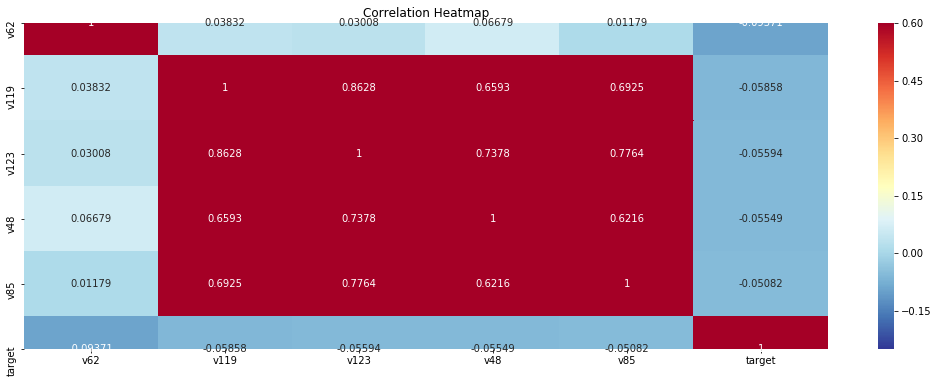

In [7]:
plt.figure(figsize = (18, 6))

# Heatmap of correlations
sns.heatmap(poly_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6, fmt='.4g')
plt.title('Correlation Heatmap');


In [8]:
# Make a new dataframe for polynomial features
poly_features = train[['v62', 'v119', 'v123', 'v48', 'v85', 'target']]
poly_features_test = test[['v62', 'v119', 'v123', 'v48', 'v85']]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['target']

poly_features = poly_features.drop(columns = ['target'], axis = 1)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 2)

In [9]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (114321, 21)


This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method.

In [10]:
print(poly_transformer.get_feature_names(input_features = ['v62', 'v119', 'v123', 'v48', 'v85'])[:15])

['1', 'v62', 'v119', 'v123', 'v48', 'v85', 'v62^2', 'v62 v119', 'v62 v123', 'v62 v48', 'v62 v85', 'v119^2', 'v119 v123', 'v119 v48', 'v119 v85']


In [11]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['v62', 'v119', 'v123', 'v48', 'v85']))

# Add in the target
poly_features['target'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['target'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

v62 v48    -0.097531
v62 v85    -0.096424
v62        -0.093709
v62 v123   -0.088911
v62 v119   -0.068526
v119       -0.047535
v119 v48   -0.046606
v123       -0.045113
v119 v85   -0.044697
v123 v48   -0.044665
Name: target, dtype: float64
v123^2   -0.039056
v85^2    -0.037538
v62^2    -0.035026
target    1.000000
1              NaN
Name: target, dtype: float64


In [12]:
poly_features.head()

,1,v62,v119,v123,v48,v85,v62^2,v62 v119,v62 v123,v62 v48,v62 v85,v119^2,v119 v123,v119 v48,v119 v85,v123^2,v123 v48,v123 v85,v48^2,v48 v85,v85^2,target
0,1.0,1.0,-6.297423e-07,1.989780,12.171733,1.707317,1.0,-6.297423e-07,1.989780,12.171733,1.707317,3.965754e-13,-1.253049e-06,-0.000008,-1.075170e-06,3.959225,24.219074,3.397185,148.151094,20.781006,2.914931,1
1,1.0,2.0,1.461561e+00,2.739239,12.411608,2.594937,4.0,2.923122e+00,5.478479,24.823216,5.189874,2.136160e+00,4.003565e+00,18.140321,3.792658e+00,7.503433,33.998366,7.108154,154.048010,32.207339,6.733697,1
2,1.0,1.0,-2.792745e-07,2.477596,12.711328,2.429906,1.0,-2.792745e-07,2.477596,12.711328,2.429906,7.799425e-14,-6.919293e-07,-0.000004,-6.786108e-07,6.138481,31.493532,6.020325,161.577852,30.887331,5.904443,1
3,1.0,1.0,5.655086e-01,1.812795,12.194855,1.587045,1.0,5.655086e-01,1.812795,12.194855,1.587045,3.198000e-01,1.025151e+00,6.896296,8.974875e-01,3.286226,22.106771,2.876987,148.714480,19.353779,2.518711,1
4,1.0,1.0,1.461561e+00,2.739239,12.411608,2.594937,1.0,1.461561e+00,2.739239,12.411608,2.594937,2.136160e+00,4.003565e+00,18.140321,3.792658e+00,7.503433,33.998366,7.108154,154.048010,32.207339,6.733697,1


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [118]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['v62', 'v119', 'v123', 'v48', 'v85']))

# Merge polynomial features into training dataframe
poly_features['ID'] = train['ID']
train_poly = train.merge(poly_features, on = 'ID', how = 'left')

# Merge polinomial features into testing dataframe
poly_features_test['ID'] = test['ID']
test_poly = test.merge(poly_features_test, on = 'ID', how = 'left')

# Align the dataframes
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', train_poly.shape)
print('Testing data with polynomial features shape:  ', test_poly.shape)

Training data with polynomial features shape:  (114321, 123)
Testing data with polynomial features shape:   (114393, 123)


In [119]:
# Remove colunas com alta correlacao entre si ou com mais de 95% com zeros
#train_poly = train_poly.drop(columns = ['1','v62_y','v119_y','v123_y','v48_y','v85_y'], axis = 1)

In [120]:
num_cols = train_poly.columns[train_poly.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [121]:
# Realizando tratamento de missing value (treino)
for col in train_poly.columns:
    if train_poly[col].dtype !='object':
        if col in ['ID','target']:
            continue

        train_poly[col].fillna(train_poly[col].median(),inplace=True)
        
# Realizando tratamento de missing value (test)
for col in test_poly.columns:
    if test_poly[col].dtype !='object':
        if col in ['ID','target']:
            continue

        test_poly[col].fillna(test_poly[col].median(),inplace=True)

In [122]:
# Add decomposed components: PCA / ICA etc.
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_train = tsvd.fit_transform(train_poly[num_cols].drop(columns = ['ID'], axis = 1))
tsvd_results_test = tsvd.fit_transform(test_poly[num_cols].drop(columns = ['ID'], axis = 1))

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train_poly[num_cols].drop(columns = ['ID'], axis = 1))
pca2_results_test = pca.fit_transform(test_poly[num_cols].drop(columns = ['ID'], axis = 1))

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train_poly[num_cols].drop(columns = ['ID'], axis = 1))
ica2_results_test = ica.fit_transform(test_poly[num_cols].drop(columns = ['ID'], axis = 1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train_poly[num_cols].drop(columns = ['ID'], axis = 1))
grp_results_test = grp.fit_transform(test_poly[num_cols].drop(columns = ['ID'], axis = 1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train_poly[num_cols].drop(columns = ['ID'], axis = 1))
srp_results_test = srp.fit_transform(test_poly[num_cols].drop(columns = ['ID'], axis = 1))

In [124]:
# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train_poly['pca_' + str(i)]  = pca2_results_train[:,i-1]
    train_poly['ica_' + str(i)]  = ica2_results_train[:,i-1]
    train_poly['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    train_poly['grp_' + str(i)]  = grp_results_train[:,i-1]
    train_poly['srp_' + str(i)]  = srp_results_train[:,i-1]
    
    test_poly['pca_' + str(i)]  = pca2_results_test[:,i-1]
    test_poly['ica_' + str(i)]  = ica2_results_test[:,i-1]
    test_poly['tsvd_' + str(i)] = tsvd_results_test[:,i-1]
    test_poly['grp_' + str(i)]  = grp_results_test[:,i-1]
    test_poly['srp_' + str(i)]  = srp_results_test[:,i-1]    

In [126]:
# Add in the target
train_poly['target'] = poly_target

# Gera dataset tratado

In [136]:
# Memory reduce
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [137]:
treino=reduce_mem_usage(train_poly)
teste=reduce_mem_usage(test_poly)

Memory usage of dataframe is 161.36 MB
Memory usage after optimization is: 88.09 MB
Decreased by 45.4%
Memory usage of dataframe is 160.59 MB
Memory usage after optimization is: 88.04 MB
Decreased by 45.2%


In [138]:
treino.to_csv('../dataset/dataset_treino_new.csv', index=False)
teste.to_csv('../dataset/dataset_teste_new.csv', index=False)